In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


2025-03-30 21:27:27.810800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 21:27:27.828422: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 21:27:27.967750: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 21:27:28.099915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743362848.208586  284607 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743362848.23

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

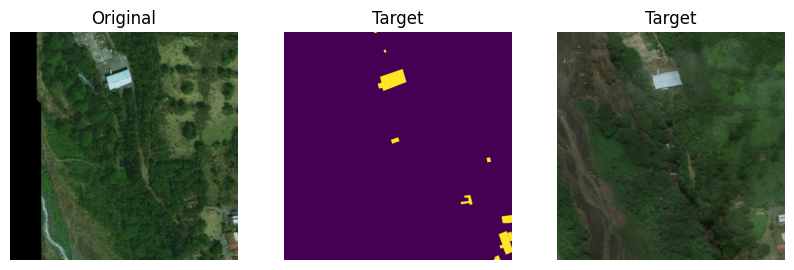

In [2]:
im2 = plt.imread('dataset/train/targets/guatemala-volcano_00000000_post_disaster_target.png')
im3 = plt.imread('dataset/train/images/guatemala-volcano_00000000_post_disaster.png')
im = plt.imread('dataset/train/images/guatemala-volcano_00000000_pre_disaster.png')
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.title('Original')
plt.imshow(im)
plt.axis('off')
plt.subplot(132)
plt.title('Target')
plt.imshow(im2)
plt.axis('off')
plt.subplot(133)
plt.title('Target')
plt.imshow(im3)
plt.axis('off')

In [ ]:

# Load JSON file
with open("dataset/train/labels/guatemala-volcano_00000000_post_disaster.json", "r") as file:
    data = json.load(file)

# Pretty-print JSON
print(json.dumps(data, indent=4))

{
    "features": {
        "lng_lat": [
            {
                "properties": {
                    "feature_type": "building",
                    "subtype": "no-damage",
                    "uid": "486b0813-ecd2-4b84-856c-9c0e42156953"
                },
                "wkt": "POLYGON ((-90.81544679490855 14.39086318334812, -90.81537467350067 14.39060467857134, -90.81584174451893 14.39043032647906, -90.81586635209965 14.39049581582557, -90.81593344431286 14.39048145754227, -90.81595559689623 14.39057367091926, -90.81587964155047 14.39059650626524, -90.81590706308843 14.39071123556855, -90.81544679490855 14.39086318334812))"
            },
            {
                "properties": {
                    "feature_type": "building",
                    "subtype": "no-damage",
                    "uid": "139cf2c8-ad52-4739-82b5-bb646b215e76"
                },
                "wkt": "POLYGON ((-90.81420592027385 14.38829423654861, -90.81421178336095 14.38832937106001, -90.814088

In [ ]:
# 1️⃣ Load and Preprocess Data
IMG_SIZE = (256, 256)
TRAIN_DATASET_PATH = "dataset/train/"
TRAIN_IMAGES_PATH = os.path.join(TRAIN_DATASET_PATH, "images")
TRAIN_MASKS_PATH = os.path.join(TRAIN_DATASET_PATH, "targets")  # Segmentation masks

TEST_DATASET_PATH = "dataset/test/"
TEST_IMAGES_PATH = os.path.join(TEST_DATASET_PATH, "images")
TEST_MASKS_PATH = os.path.join(TEST_DATASET_PATH, "targets")  # Segmentation masks

# Load Images and Masks functions
def load_image(image_path):
    """Load and preprocess an image."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Failed to load image: {image_path}")
        return None
    print(f"✅ Loaded image {image_path}, Shape: {img.shape}, Dtype: {img.dtype}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, IMG_SIZE)  # Resize
    return img / 255.0  # Normalize

def load_mask(mask_path):
    """Load and preprocess a segmentation mask."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    if mask is None:
        print(f"❌ Failed to load mask: {mask_path}")
        return None
    print(f"✅ Loaded mask {mask_path}, Shape: {mask.shape}, Dtype: {mask.dtype}")
    mask = cv2.resize(mask, IMG_SIZE)
    return np.expand_dims(mask, axis=-1) / 255.0  # Normalize and add channel

# Create a list of the images and masks to load
train_image_filenames = sorted([
    f for f in os.listdir(TRAIN_IMAGES_PATH) 
    if "_pre_disaster.png" in f and not f.startswith(".") and ":Zone.Identifier" not in f # Exclude Windows Zone Identifier files
])

test_image_filenames = sorted([
    f for f in os.listdir(TEST_IMAGES_PATH) 
    if "_pre_disaster.png" in f and not f.startswith(".") and ":Zone.Identifier" not in f
])


2025-03-30 19:29:49.992789: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 19:29:49.999124: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 19:29:50.027197: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 19:29:50.061594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743355790.091646  254443 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743355790.09

In [14]:
print("TRAIN_IMAGES_PATH = " + TRAIN_IMAGES_PATH)
print("TRAIN_MASKS_PATH = " + TRAIN_MASKS_PATH)
print("train_image_filenames = " + str(train_image_filenames))
print("test_image_filenames = " + str(test_image_filenames))
print(len(test_image_filenames))


TRAIN_IMAGES_PATH = dataset/train/images
TRAIN_MASKS_PATH = dataset/train/targets
train_image_filenames = ['guatemala-volcano_00000000_pre_disaster.png', 'guatemala-volcano_00000001_pre_disaster.png', 'guatemala-volcano_00000002_pre_disaster.png', 'guatemala-volcano_00000006_pre_disaster.png', 'guatemala-volcano_00000007_pre_disaster.png', 'guatemala-volcano_00000008_pre_disaster.png', 'guatemala-volcano_00000010_pre_disaster.png', 'guatemala-volcano_00000013_pre_disaster.png', 'guatemala-volcano_00000015_pre_disaster.png', 'guatemala-volcano_00000016_pre_disaster.png', 'guatemala-volcano_00000017_pre_disaster.png', 'guatemala-volcano_00000018_pre_disaster.png', 'guatemala-volcano_00000019_pre_disaster.png', 'guatemala-volcano_00000023_pre_disaster.png', 'guatemala-volcano_00000024_pre_disaster.png', 'guatemala-volcano_00000025_pre_disaster.png', 'guatemala-volcano_00000026_pre_disaster.png', 'guatemala-volcano_00000027_pre_disaster.png', 'hurricane-florence_00000000_pre_disaster.png',

In [20]:
# CREATE X_train AND Y_train 

# Initialize lists to store images and masks
X_train, Y_train = [], []

# Limit the number of images to load for faster training
image_count = 0
image_number_to_load = 600  # Limit the number of images to load

for filename in train_image_filenames:
    # Skip Zone Identifier files or hidden system files
    if filename.startswith(".") or ":Zone.Identifier" in filename:
        continue
    pre_disaster_img = load_image(os.path.join(TRAIN_IMAGES_PATH, filename))
    post_disaster_img = load_image(os.path.join(TRAIN_IMAGES_PATH, filename.replace("_pre_disaster", "_post_disaster")))

    # Update the filenames for pre and post disaster masks
    #pre_mask_filename = filename.replace("_pre_disaster.png", "_pre_disaster_target.png")
    post_mask_filename = filename.replace("_pre_disaster.png", "_post_disaster_target.png")
    
    # Load corresponding pre and post disaster masks
    #pre_mask_path = os.path.join(TRAIN_MASKS_PATH, pre_mask_filename)
    post_mask_path = os.path.join(TRAIN_MASKS_PATH, post_mask_filename)

    #pre_mask_img = load_mask(pre_mask_path)
    post_mask_img = load_mask(post_mask_path)
    
    #if pre_mask_img is None or post_mask_img is None:
    if post_mask_img is None:
        continue  # Skip images if either mask is missing

    # Concatenate pre- and post-disaster images along the channel axis
    stacked_image = np.concatenate([pre_disaster_img, post_disaster_img], axis=-1)  # Shape: (256, 256, 6)
    
    # Store the processed data
    X_train.append(stacked_image)
    Y_train.append(post_mask_img)  # Use only post-disaster mask, shape: (256, 256, 1)

    # Limit the number of images to 1000 for faster training
    image_count += 1
    if image_count >= image_number_to_load:
        print(f"✅ Loaded {image_count} train images and masks.")
        break

X_train = np.array(X_train)
Y_train = np.array(Y_train)

✅ Loaded image dataset/train/images/guatemala-volcano_00000000_pre_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded image dataset/train/images/guatemala-volcano_00000000_post_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded mask dataset/train/targets/guatemala-volcano_00000000_post_disaster_target.png, Shape: (1024, 1024), Dtype: uint8
✅ Loaded image dataset/train/images/guatemala-volcano_00000001_pre_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded image dataset/train/images/guatemala-volcano_00000001_post_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded mask dataset/train/targets/guatemala-volcano_00000001_post_disaster_target.png, Shape: (1024, 1024), Dtype: uint8
✅ Loaded image dataset/train/images/guatemala-volcano_00000002_pre_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded image dataset/train/images/guatemala-volcano_00000002_post_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded mask dataset/train/targets/guatema

In [17]:
# CREATE X_test AND Y_test 

# Initialize lists to store images and masks
X_test, Y_test = [], []

# Limit the number of images to load for faster training
image_count = 0
image_number_to_load = 300  # Limit the number of images to load

for filename in test_image_filenames:
    # Skip Zone Identifier files or hidden system files
    if filename.startswith(".") or ":Zone.Identifier" in filename:
        continue
    pre_disaster_img = load_image(os.path.join(TEST_IMAGES_PATH, filename))
    post_disaster_img = load_image(os.path.join(TEST_IMAGES_PATH, filename.replace("_pre_disaster", "_post_disaster")))

    # Update the filenames for pre and post disaster masks
    #pre_mask_filename = filename.replace("_pre_disaster.png", "_pre_disaster_target.png")
    post_mask_filename = filename.replace("_pre_disaster.png", "_post_disaster_target.png")
    
    # Load corresponding pre and post disaster masks
    #pre_mask_path = os.path.join(TEST_MASKS_PATH, pre_mask_filename)
    post_mask_path = os.path.join(TEST_MASKS_PATH, post_mask_filename)

    #pre_mask_img = load_mask(pre_mask_path)
    post_mask_img = load_mask(post_mask_path)
    
    #if pre_mask_img is None or post_mask_img is None:
    if post_mask_img is None:
        continue  # Skip images if either mask is missing

    # Concatenate pre- and post-disaster images along the channel axis
    stacked_image = np.concatenate([pre_disaster_img, post_disaster_img], axis=-1)  # Shape: (256, 256, 6)
    
    # Store the processed data
    X_test.append(stacked_image)
    Y_test.append(post_mask_img)  # Use only post-disaster mask, shape: (256, 256, 1)

    # Limit the number of images to 1000 for faster training
    image_count += 1
    if image_count >= image_number_to_load:
        print(f"✅ Loaded {image_count} test images and masks.")
        break

X_test = np.array(X_test)
Y_test = np.array(Y_test)

✅ Loaded image dataset/test/images/guatemala-volcano_00000003_pre_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded image dataset/test/images/guatemala-volcano_00000003_post_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded mask dataset/test/targets/guatemala-volcano_00000003_post_disaster_target.png, Shape: (1024, 1024), Dtype: uint8
✅ Loaded image dataset/test/images/guatemala-volcano_00000005_pre_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded image dataset/test/images/guatemala-volcano_00000005_post_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded mask dataset/test/targets/guatemala-volcano_00000005_post_disaster_target.png, Shape: (1024, 1024), Dtype: uint8
✅ Loaded image dataset/test/images/guatemala-volcano_00000009_pre_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded image dataset/test/images/guatemala-volcano_00000009_post_disaster.png, Shape: (1024, 1024, 3), Dtype: uint8
✅ Loaded mask dataset/test/targets/guatemala-volcan

In [21]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape) 
print(Y_test.shape)



(600, 256, 256, 6)
(600, 256, 256, 1)
(300, 256, 256, 6)
(300, 256, 256, 1)


In [19]:

# 2️⃣ Define U-Net Model
def unet_model(input_shape=(256, 256, 6)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c7)  # Binary segmentation output
    model = Model(inputs, outputs)
    return model

# 3️⃣ Compile and Train Model
model = unet_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


2025-03-30 19:35:44.043848: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [23]:
print(tf.config.list_physical_devices('GPU'))  # Should list available GPUs

[]


In [ ]:
# 3️⃣ Train Model


model.fit(X_train, Y_train, epochs=10, batch_size=2, validation_split=0.2, shuffle=True)
# Save the model
model.save("models/unet_model.h5")



Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 158s 657ms/step - accuracy: 0.9505 - loss: 0.0026 - val_accuracy: 0.8896 - val_loss: 0.0055
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 157s 665ms/step - accuracy: 0.9464 - loss: 0.0028 - val_accuracy: 0.8896 - val_loss: 0.0060
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 162s 674ms/step - accuracy: 0.9499 - loss: 0.0026 - val_accuracy: 0.8896 - val_loss: 0.0054
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 156s 651ms/step - accuracy: 0.9514 - loss: 0.0024 - val_accuracy: 0.8896 - val_loss: 0.0053
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 163s 679ms/step - accuracy: 0.9525 - loss: 0.0024 - val_accuracy: 0.8896 - val_loss: 0.0064
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 163s 679ms/step - accuracy: 0.9531 - loss: 0.0024 - val_accuracy: 0.8896 - val_loss: 0.0055
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 162s 677ms/step - accuracy: 0.9452 - loss: 0.0025 - val_accuracy: 0.8896 - val_loss: 0.0055
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 165s 687ms/step - accuracy: 0.9486 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


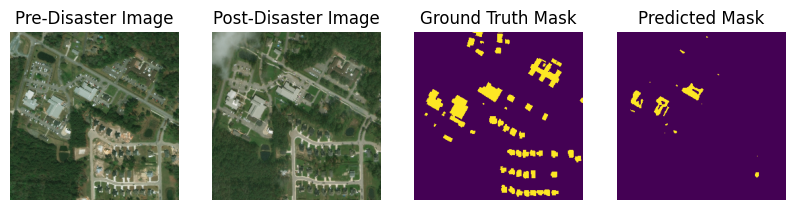

In [63]:

im_no = 17
after_img = X_test[im_no]
mask_img = Y_test[im_no]

# 4️⃣ Predict and Visualize Results
pred_mask = model.predict(np.expand_dims(after_img, axis=0))[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(after_img[..., :3])  # Show only the first 3 RGB channels
plt.title("Pre-Disaster Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(after_img[..., 3:])  # Show only the first 3 RGB channels
plt.title("Post-Disaster Image")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(mask_img)
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(pred_mask > 0.002)  # Threshold the predicted mask
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

Text(0, 0.5, 'Frequency')

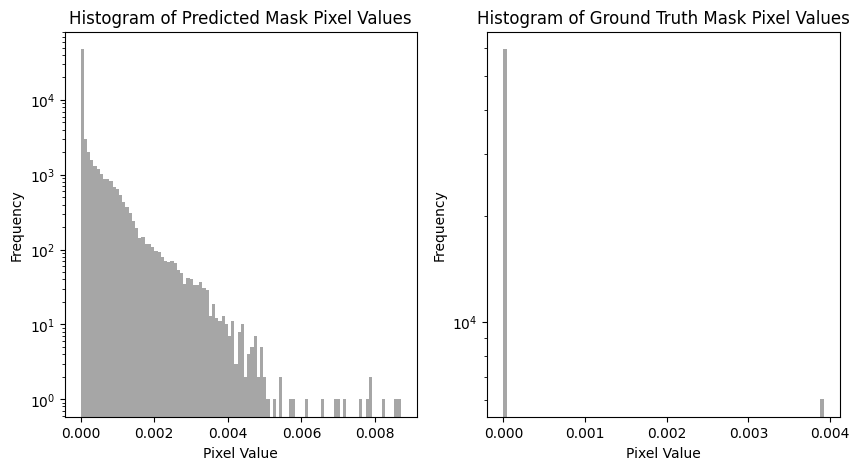

In [58]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(pred_mask.squeeze().flatten(), bins=100, color='gray', alpha=0.7, log=True)
plt.title("Histogram of Predicted Mask Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(mask_img.squeeze().flatten(), bins=100, color='gray', alpha=0.7, log=True)
plt.title("Histogram of Ground Truth Mask Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
